In [1]:
import numpy as np
from torch_geometric.datasets import Coauthor, CitationFull, Reddit2
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
from torch_geometric.utils import homophily
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm.notebook import tqdm
from utils import *
import pandas as pd
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle as pkl
import os
import itertools
%load_ext autoreload
%autoreload 2


In [2]:
dataset = Reddit2('data/Reddit2')
data = dataset[0]
test_subgraph = data.subgraph(data.test_mask)
test_subgraph

Data(x=[55334, 602], edge_index=[2, 1615610], y=[55334], train_mask=[55334], val_mask=[55334], test_mask=[55334])

In [3]:
homophily(data.edge_index, data.y, method='node')

0.8128384351730347

In [4]:
G = to_networkx(test_subgraph).to_undirected()

In [5]:
G

In [6]:
def get_nbhd_weights(G, node, k, scheme='unif'):
    # Get dict containing nodes -> shortest path to node (i.e. depth).
    node_depth_map = pd.Series(nx.single_source_shortest_path_length(G, node, cutoff=k), name='distance')
    node_depth_map.index.name = 'node_id'
    node_depth_map = node_depth_map.drop(node) # Remove the node itself from list.
    node_depth_map = node_depth_map.reset_index()

    if scheme == 'geom':
        node_depth_map['weight'] = (0.5)**(node_depth_map['distance'])  # Weight =
    elif scheme == 'linear':
        node_depth_map['weight'] = 1 / node_depth_map['distance']
    else:
        node_depth_map['weight'] = 1
    return node_depth_map

In [7]:
# exp_path = 'experiments/10-09-2022_01-43-40_Reddit2' # MEAN
# exp_path = 'experiments/12-09-2022_18-25-57_Reddit2' # MAX
exp_path = 'experiments/14-09-2022_23-49-12_Reddit2_SHADOW'
preds_path = os.path.join(exp_path, 'preds.pkl')
with open(preds_path, 'rb') as f:
    preds = pkl.load(f)
preds = pd.DataFrame(preds)
test_x = pd.DataFrame(data.x[data.test_mask].numpy())
test_y = pd.DataFrame(data.y[data.test_mask].numpy())

print(len(preds))
print(len(test_x))
print(len(test_y))

55334
55334
55334


In [8]:
probs = test_y.value_counts() / len(test_y)
probs.name = 'Proportion'
probs.index.name = 'Class'
probs
sum(probs**2)

0.05173550222890036

In [9]:
preds

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2.097040e-04,4.343497e-05,2.734680e-06,3.046737e-09,5.720815e-05,5.921852e-03,1.587953e-02,2.869732e-02,5.169243e-07,4.401381e-02,...,1.367339e-01,5.736105e-03,1.652083e-04,2.590278e-07,5.223031e-06,1.842429e-04,9.304295e-02,5.159779e-04,5.132282e-02,1.318013e-02
1,4.030139e-03,1.080441e-07,4.043911e-12,5.465040e-06,2.608795e-12,3.324255e-16,1.467974e-03,4.203566e-04,2.617328e-19,7.660101e-05,...,1.711264e-16,7.365445e-07,4.019323e-18,6.278524e-19,2.717979e-08,5.526345e-17,1.164845e-10,1.963363e-03,3.042301e-10,1.914610e-04
2,7.279528e-04,1.940651e-06,1.357225e-09,1.762215e-05,1.807786e-09,3.101254e-12,1.248065e-01,9.260973e-05,5.098856e-16,1.697828e-04,...,1.147299e-12,2.209316e-05,1.661342e-14,7.233445e-19,1.126423e-07,3.941233e-12,6.844430e-07,2.091096e-03,1.625506e-06,2.657857e-03
3,9.985110e-01,9.854977e-08,7.976008e-12,9.085338e-09,1.915550e-12,3.804032e-29,2.007727e-13,3.160819e-05,4.512987e-23,5.974614e-14,...,7.507510e-32,3.174714e-08,1.395714e-22,9.487998e-16,6.219537e-11,4.334722e-22,8.264773e-20,2.372872e-11,1.253602e-17,1.301402e-08
4,1.782998e-04,8.665255e-04,7.884552e-10,9.915460e-01,4.654495e-12,7.620431e-28,6.752037e-09,4.951878e-12,2.443330e-22,4.111193e-15,...,3.767835e-32,2.215425e-11,2.125272e-23,1.693666e-22,5.986276e-09,2.925249e-18,3.563842e-19,1.570850e-07,1.998879e-15,2.493340e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55329,4.743563e-05,3.541026e-04,6.823400e-05,2.296829e-06,8.827064e-05,1.929262e-10,3.815996e-02,1.328551e-07,2.812631e-12,1.132073e-07,...,2.263782e-12,1.981310e-03,1.143316e-10,1.554700e-18,5.258526e-08,1.939701e-05,6.814365e-04,2.604433e-06,9.339639e-03,3.185757e-03
55330,8.442882e-09,1.708048e-08,2.871376e-07,8.706020e-09,6.936628e-08,2.549154e-07,3.233491e-04,3.211103e-09,9.302781e-07,1.760841e-04,...,1.087709e-13,3.836446e-07,2.058630e-08,3.680561e-11,2.529937e-01,6.540254e-12,3.107405e-07,6.937185e-02,9.642009e-07,3.883517e-01
55331,3.889793e-16,7.185902e-17,8.206583e-11,3.145602e-19,4.325720e-11,6.968249e-08,6.553013e-07,2.972108e-15,5.720495e-10,1.944641e-07,...,3.288603e-17,7.288298e-09,1.517237e-11,4.365585e-20,1.076930e-05,9.920968e-16,5.967110e-07,3.736209e-07,9.839296e-08,9.720272e-03
55332,9.968169e-11,4.214753e-08,2.494031e-01,6.329249e-17,5.900053e-01,8.186513e-11,1.446010e-10,1.935960e-14,1.051648e-05,2.084080e-15,...,1.254201e-18,1.105592e-03,1.875736e-05,6.661903e-14,8.580054e-09,1.073210e-02,1.081247e-04,1.954805e-15,3.160506e-03,5.327676e-05


In [10]:
G.number_of_nodes()

55334

In [11]:
## Compute the NAPS prediction set for each node in advance.
alpha = 0.1
cutoff = 30
quantiles_nb = []
def calibrate_nbhd(node, scheme='unif'):
    nbs = get_nbhd_weights(G, node, k=1, scheme=scheme)
    nb_ids = nbs['node_id'].values
    weights = nbs['weight'].values
    if cutoff <= len(nb_ids):
        quantile = calibrate_weighted(preds.loc[nb_ids].values,
                             np.squeeze(test_y.loc[nb_ids].values),
                                      weights, alpha)
        return {node: quantile}

In [12]:
def precompute_naps_sets(scheme):
    f = partial(calibrate_nbhd, scheme=scheme)
    quantiles_nb = process_map(f, list(G.nodes), max_workers=12)
    nz = [p for p in quantiles_nb if p is not None]
    res = {}
    for p in nz:
        res.update(p)
    nbhd_quantiles = pd.Series(res, name='quantile')
    nbhd_quantiles
    lcc_nodes = nbhd_quantiles.index.values
    sets_nb = predict(preds.loc[lcc_nodes].values, nbhd_quantiles.values[:, None])
    sets_nb = pd.Series(sets_nb, index=lcc_nodes, name='set')
    sets_nb = pd.DataFrame(sets_nb)
    sets_nb['set_size'] = sets_nb['set'].apply(len)
    sets_nb['covers'] = [test_y.loc[i].values in sets_nb.loc[i, 'set'] for i in sets_nb.index.values]
    return sets_nb, lcc_nodes


In [13]:
napsg_sets, _ = precompute_naps_sets('geom')
naps_sets, lcc_nodes = precompute_naps_sets('unif')
napsl_sets, _ = precompute_naps_sets('linear')

/tmp/ipykernel_23602/2225987536.py:3: TqdmWarning: Iterable length 55334 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/55334 [00:00<?, ?it/s]

/tmp/ipykernel_23602/2225987536.py:3: TqdmWarning: Iterable length 55334 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/55334 [00:00<?, ?it/s]

/tmp/ipykernel_23602/2225987536.py:3: TqdmWarning: Iterable length 55334 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/55334 [00:00<?, ?it/s]

In [14]:
naps_sets.groupby('set_size').count()

,set,covers
set_size,,
0,1278,1278
1,13085,13085
2,2444,2444
3,1006,1006
4,514,514
5,373,373
6,246,246
7,161,161
8,101,101


In [15]:
n_trials = 100
n_eval = 1000
sccv_bins = [-1, 1, 2, 3, 40]

In [16]:
naps_stats = []
napsl_stats = []
napsg_stats = []
full_stats = []
# with mp.Pool(12) as p:
for k in tqdm(range(n_trials)):
    ## Sample the prediction nodes.
    pred_nodes = np.random.choice(lcc_nodes, size=n_eval, replace=False)
    # Neighbourhood calibration is pre-computed, so just get prediction sets for them.
    naps_stats.append(evaluate_predictions(naps_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))
    napsl_stats.append(evaluate_predictions(napsl_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))
    napsg_stats.append(evaluate_predictions(napsg_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))

    # Full calibration
    quantile = calibrate(preds[~preds.index.isin(pred_nodes)].values,
                         np.squeeze(test_y[~test_y.index.isin(pred_nodes)].values), alpha)
    sets_full = predict(preds.loc[pred_nodes].values, quantile)
    full_stats.append(evaluate_predictions(sets_full,
                                           test_x.loc[pred_nodes].values,
                                           np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins))


  0%|          | 0/100 [00:00<?, ?it/s]

[0.9074585635359116, 0.9928571428571429, 0.9615384615384616, 0.8809523809523809]
[0.8948824343015215, 0.9862068965517241, 0.9333333333333333, 0.896551724137931]
[0.9166666666666666, 0.9873417721518988, 0.9285714285714286, 0.9117647058823529]
[0.9056603773584906, 0.9934640522875817, 1.0, 0.8818897637795275]
[0.9092122830440588, 0.943089430894309, 0.9824561403508771, 0.9577464788732394]
[0.9171195652173914, 0.950354609929078, 1.0, 0.9466666666666667]
[0.8990182328190743, 0.971830985915493, 0.9821428571428571, 0.9662921348314607]
[0.9138461538461539, 0.9733333333333334, 0.9882352941176471, 0.9739130434782609]
[0.9050894085281981, 0.9927536231884058, 0.9591836734693877, 0.8837209302325582]
[0.893646408839779, 0.9854014598540146, 0.9782608695652174, 0.8709677419354839]
[0.9291907514450867, 1.0, 0.9555555555555556, 0.9130434782608695]
[0.9040880503144654, 0.9933774834437086, 0.9753086419753086, 0.9318181818181818]
[0.8924302788844621, 0.967479674796748, 1.0, 0.88]
[0.9062918340026773, 0.9918

,coverage,set_size,cc_set_size,sscv
count,100.00000,100.000000,100.000000,100.000000
mean,0.91700,1.607610,1.679867,0.082633
std,0.00902,0.054701,0.052701,0.013556
min,0.88900,1.433000,1.551609,0.049640
25%,0.91100,1.572000,1.649783,0.074784
50%,0.91800,1.604000,1.676452,0.082684
75%,0.92200,1.645750,1.717184,0.100000
max,0.93600,1.743000,1.826944,0.100000


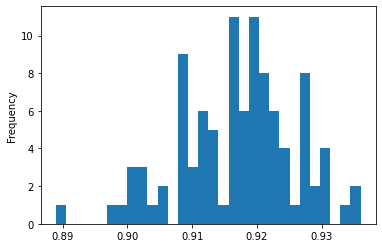

In [17]:
nb_df = pd.DataFrame(naps_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size,sscv
count,100.000000,100.000000,100.000000,100.000000
mean,0.915630,1.610280,1.685615,0.082835
std,0.008219,0.052736,0.054874,0.014903
min,0.897000,1.447000,1.533696,0.042029
25%,0.910000,1.572500,1.649148,0.074132
50%,0.915500,1.610500,1.688423,0.083470
75%,0.921000,1.640750,1.717875,0.100000
max,0.938000,1.740000,1.808952,0.100000


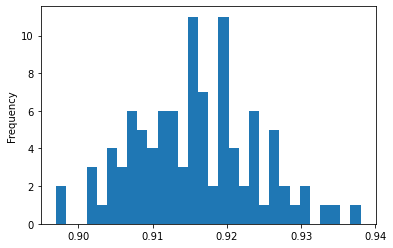

In [18]:
nb_df = pd.DataFrame(napsl_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size,sscv
count,100.000000,100.000000,100.000000,100.000000
mean,0.933810,1.811460,1.877420,0.088250
std,0.007016,0.067226,0.070226,0.010129
min,0.917000,1.622000,1.698073,0.061240
25%,0.929000,1.766500,1.835826,0.083538
50%,0.934000,1.813000,1.877830,0.090813
75%,0.938000,1.853750,1.919533,0.100000
max,0.949000,1.968000,2.049073,0.100000


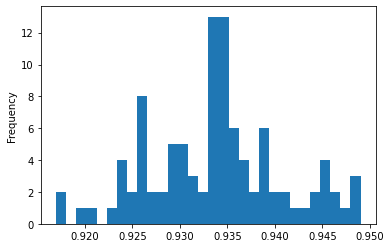

In [19]:
nb_df = pd.DataFrame(napsg_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size,sscv
count,100.000000,100.000000,100.000000,100.000000
mean,0.931110,1.876150,1.949918,0.091045
std,0.007561,0.059476,0.062399,0.009255
min,0.907000,1.719000,1.803648,0.064706
25%,0.926000,1.831750,1.898625,0.086183
50%,0.931500,1.871000,1.942277,0.093006
75%,0.936000,1.920000,1.993021,0.100000
max,0.950000,2.004000,2.108911,0.100000


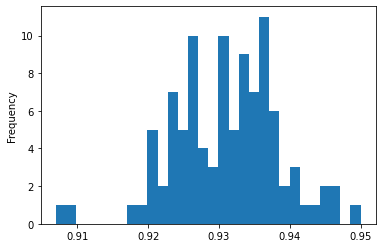

In [20]:
full_df = pd.DataFrame(full_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
full_df['coverage'].plot(kind='hist', bins=30)
full_df.describe()

Conditional Coverage:
- Split the data into 2 parts, calibrate APS on one half, pre-calibrate NAPS on everything.
- On the 'Evaluation' half, take the subgraph of these nodes within the network. Take a number of neighbourhoods, look at the worst case violation of the neighbourhood conditional coverage. Compare this metric with the APS calibration. Repeat experiment a number of times

In [ ]:
from random import sample
## Split the test nodes into non-overlapping neighbourhoods
def split_into_neighbourhoods(test_nodes):
    test_subgraph = G.subgraph(test_nodes).copy()
    nbhds = []
    while test_subgraph.number_of_nodes() > 0:
        root = sample(list(test_subgraph.nodes()), 1)[0]
        nbhd_nodes = list(nx.single_source_shortest_path_length(test_subgraph, root, cutoff=2).keys())
        nbhds.append(nbhd_nodes)
        test_subgraph.remove_nodes_from(nbhd_nodes)
    return sorted(nbhds, key=lambda x: len(x), reverse=True)[:20]


In [ ]:
# pred_nodes = np.random.choice(lcc_nodes, size=len(lcc_nodes) // 2, replace=False)'
aps_nccvs = []
naps_nccvs = []
napsl_nccvs = []
napsg_nccvs = []
for k in tqdm(range(n_trials)):
    np.random.shuffle(lcc_nodes)
    n_calib = len(lcc_nodes) // 2
    calib_nodes = lcc_nodes[:n_calib]
    test_nodes = lcc_nodes[n_calib:]

    ## Calibrate the regular CP on calibration nodes and make predictions on test nodes
    quantile = calibrate(preds.loc[calib_nodes].values,
                         np.squeeze(test_y.loc[calib_nodes].values), alpha)
    sets_full = pd.Series(predict(preds.loc[test_nodes].values, quantile), index=test_nodes)
    nbhds = split_into_neighbourhoods(test_nodes)
    aps_nb_coverages = []
    naps_nb_coverages = []
    napsl_nb_coverages = []
    napsg_nb_coverages = []

    for nbhd in nbhds:
        aps_nb_coverages.append(np.mean([test_y.loc[node].item() in sets_full[node] for node in nbhd]))
        naps_nb_coverages.append(naps_sets.loc[nbhd, 'covers'].mean())
        napsl_nb_coverages.append(napsl_sets.loc[nbhd, 'covers'].mean())
        napsg_nb_coverages.append(napsg_sets.loc[nbhd, 'covers'].mean())

    aps_nccv = max(np.abs(np.array(aps_nb_coverages) - (1 - alpha)))
    naps_nccv = max(np.abs(np.array(naps_nb_coverages) - (1 - alpha)))
    napsl_nccv = max(np.abs(np.array(napsl_nb_coverages) - (1 - alpha)))
    napsg_nccv = max(np.abs(np.array(napsg_nb_coverages) - (1 - alpha)))

    aps_nccvs.append(aps_nccv)
    naps_nccvs.append(naps_nccv)
    napsl_nccvs.append(napsl_nccv)
    napsg_nccvs.append(napsg_nccv)


In [ ]:
pd.DataFrame(aps_nccvs).describe()

In [ ]:
pd.DataFrame(naps_nccvs).describe()

In [ ]:
pd.DataFrame(napsl_nccvs).describe()

In [ ]:
pd.DataFrame(napsg_nccvs).describe()

In [ ]:
# def get_neighbourhoods(G, test_nodes, nbhd_size=2):

In [ ]:
# print(nbhds[0].index(1700))

In [ ]:
test_y

In [ ]:
lcc_nodes